In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [2]:
function SandT(x1, y1, x2, y2, x3, y3)
    global LOCALEDGENODES

    area = .5abs(det([1. x1 y1
                      1. x2 y2
                      1. x3 y3]))
    temp = inv([x1 x2 x3
                y1 y2 y3
                1. 1. 1.])
    b = temp[:,1]
    c = temp[:,2]
    a = temp[:,3]
    ∇λ = [[b[1], c[1]],
          [b[2], c[2]],
          [b[3], c[3]]]
    φ = zeros(3, 3) # φij = ∇λi ⋅ ∇λj = (bi⋅ci + bj⋅cj)
    v = zeros(3, 3) # vij = ∇λi × ∇λj = (bi⋅cj - bj⋅ci)ẑ
    for ii = 1:3
       for jj = 1:3
           φ[ii, jj] = b[ii] * b[jj] + c[ii] * c[jj]
           v[ii, jj] = b[ii] * c[jj] - b[jj] * c[ii]
       end 
    end

    M = [2. 1. 1.
         1. 2. 1.
         1. 1. 2.] / 12.0

    # Compute S and T
    S = zeros(3, 3)
    T = zeros(3, 3)
    for ii = 1:3
       for jj = 1:3
         i1 = LOCALEDGENODES[ii,1]
         i2 = LOCALEDGENODES[ii,2]
         j1 = LOCALEDGENODES[jj,1]
         j2 = LOCALEDGENODES[jj,2]
         S[ii,jj] = 4area*v[i1, i2] * v[j1, j2]
         T[ii,jj] = area*(φ[i2, j2] * M[i1, j1] +
                        - φ[i2, j1] * M[i1, j2] +
                        - φ[i1, j2] * M[i2, j1] +
                        + φ[i1, j1] * M[i2, j2])
       end 
    end
    
    return S, T
end

SandT (generic function with 1 method)

In [3]:
function ABC(x1, y1, x2, y2, x3, y3, n̂)
    global LOCALEDGENODES

    len  = 0.01 # FIXME!
    temp = inv([x1 x2 x3
                y1 y2 y3
                1. 1. 1.])
    b = temp[:,1]
    c = temp[:,2]
    a = temp[:,3]
    λ  = []
    ∇λ = [[b[1], c[1]],
          [b[2], c[2]],
          [b[3], c[3]]]
    
    n = zeros(3) # ni = (n̂ × ∇λi)ẑ
    for ii = 1:3
       n[ii] = n̂[1] * ∇λ[ii][2] - n̂[2] * ∇λ[ii][1]
    end
    
    ψ = zeros(3, 3) # ψij = (n̂ × ∇λi) ⋅ (n̂ × ∇λj) = 
    for ii = 1:3
       for jj = 1:3
           ψ[ii, jj] = n[ii] * n[jj]
       end 
    end

    B = zeros(3, 3)
    for ii = 1:3
      i1 = LOCALEDGENODES[ii,1]
      i2 = LOCALEDGENODES[ii,2]
      B[ii,ii] = len * ψ[ii,ii] # FIXME!
    end
    
    return B
end

ABC (generic function with 1 method)

In [4]:
function simplex2D(elem_num, xp, yp)
    global ELEMENTS
    global NODE_COORD 

    trinodes = ELEMENTS[elem_num, :]; 
    x1 = NODE_COORD[trinodes[1],1];
    y1 = NODE_COORD[trinodes[1],2];
    x2 = NODE_COORD[trinodes[2],1];
    y2 = NODE_COORD[trinodes[2],2];
    x3 = NODE_COORD[trinodes[3],1];
    y3 = NODE_COORD[trinodes[3],2];

    σ0 = det([1. x1 y1; 1. x2 y2; 1. x3 y3]);
    σ1 = det([1. xp yp; 1. x2 y2; 1. x3 y3]);
    σ2 = det([1. x1 y1; 1. xp yp; 1. x3 y3]);
    σ3 = det([1. x1 y1; 1. x2 y2; 1. xp yp]);
    λ  = [σ1/σ0, σ2/σ0, σ3/σ0]
    return λ
end

simplex2D (generic function with 1 method)

In [5]:
# Circuit
Rs = 0.001  # Ω
RL = 2.000  # Ω
CL = 10e-12 # F

# Parameters
Δt = 0.01e-9 
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
# Meshing
a = 1.00 # m
b = 0.02 # m
nothing

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


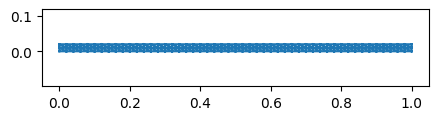

In [6]:
using PyPlot

LOCALEDGENODES = [1 2; 1 3; 2 3]
trimesh(a, b, 50, 2)
triedgemake()

figure(figsize=(5,1))
triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
axis("equal");

In [7]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_ABC  = 3
DOF_CIR  = 4

function dof_type(a, b)
    global NUM_EDGES
    global EDGES
    global NODE_COORD
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
       node1 = EDGES[i_edge, 1]
       node2 = EDGES[i_edge, 2]
       if NODE_COORD[node1, 2] ≈ 0. && NODE_COORD[node2, 2] ≈ 0.
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 2] ≈ b  && NODE_COORD[node2, 2] ≈ b
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ 0. && NODE_COORD[node2, 1] ≈ 0.
           dof_flag[i_edge] = DOF_SRC
       end
       if NODE_COORD[node1, 1] ≈ a  && NODE_COORD[node2, 1] ≈ a
           dof_flag[i_edge] = DOF_ABC
       end
       if NODE_COORD[node1, 1] ≈ .4 && NODE_COORD[node2, 1] ≈ .4
           dof_flag[i_edge] = DOF_CIR
       end
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [8]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(a, b);
NUM_DOFS = NUM_EDGES;

In [9]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

for ielem = 1:NUM_ELEMS # Assemble by elements
  trinodes = ELEMENTS[ielem, :]
  Se, Te = SandT(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
                 NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
                 NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2])
  Be = ABC(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
           NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
           NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2], n̂)
  
  for jedge = 1:3
    jj = dof[ELEMENT_EDGES[ielem, jedge]]
    for kedge = 1:3
      kk = dof[ELEMENT_EDGES[ielem, kedge]]
      S[jj, kk] = S[jj, kk] + (1/μr) * Se[jedge, kedge]
      R[jj, kk] = R[jj, kk] + (μ0*σ) * Te[jedge, kedge]
      T[jj, kk] = T[jj, kk] + (μ0*ε) * Te[jedge, kedge]
    end
    
    if Γ[jj] == DOF_ABC
      B[jj, jj] = B[jj, jj] + (μ0/η) * Be[1, 1]
    end
  end
end

In [10]:
P = spzeros(NUM_DOFS, NUM_DOFS) # μ0 / L
G = spzeros(NUM_DOFS, NUM_DOFS) # μ0 / R
C = spzeros(NUM_DOFS, NUM_DOFS) # μ0 * C
for ii = 1:NUM_EDGES
  node1 = EDGES[ii, 1]
  node2 = EDGES[ii, 2]

  if Γ[ii] == DOF_CIR
    len = norm(NODE_COORD[node1,:] - NODE_COORD[node2,:])
    G[dof[ii], dof[ii]] += μ0 / RL * (b / len)
    C[dof[ii], dof[ii]] += μ0 * CL * (b / len)
  end

  if Γ[ii] == DOF_SRC
    len = norm(NODE_COORD[node1,:] - NODE_COORD[node2,:])
    G[dof[ii], dof[ii]] += μ0 / Rs * (b / len)
  end

end
S += P
R += G
T += C
nothing

In [11]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  node1 = EDGES[ii, 1]
  node2 = EDGES[ii, 2]

  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [12]:
it  = 1
nt  = 1000
t   = 0.0
e   = zeros(NUM_EDGES)
ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
res = zeros(nt, 11, 3, 2)
vol = zeros(nt)
nothing

In [13]:
function current(t) 
    if 0e-9 < t < 0.5e-9 return +1.0 end
    if 2e-9 < t < 2.5e-9 return -1.0 end
    return 0.0
end

for _ = it:nt
    bi = (-0.25Δt^2 * S -  T + 0.5Δt * B + 0.5Δt * R) * epp +
         (-0.50Δt^2 * S + 2T) * ep
         
    bbi = zeros(NUM_EDGES)
    for ii = 1:NUM_EDGES
      node1 = EDGES[ii, 1]
      node2 = EDGES[ii, 2]
      if Γ[ii] == DOF_SRC
            len = norm(NODE_COORD[node1,:] - NODE_COORD[node2,:])
            bbi[dof[ii]] = len * current(t) / Rs
      end
    end
    
    e   .= A \ (bi + μ0 * Δt * bbi)
    epp .= ep
    ep  .= e
    
    res[it, :, :, :] .= evaluate(WhitneyTriangleElement(), e, dof, 0.01:0.05:0.51, 0.005:0.005:0.015)
    vol[it] = sum(e[dof[Γ .== DOF_CIR]])
    it += 1
    t  += Δt
end

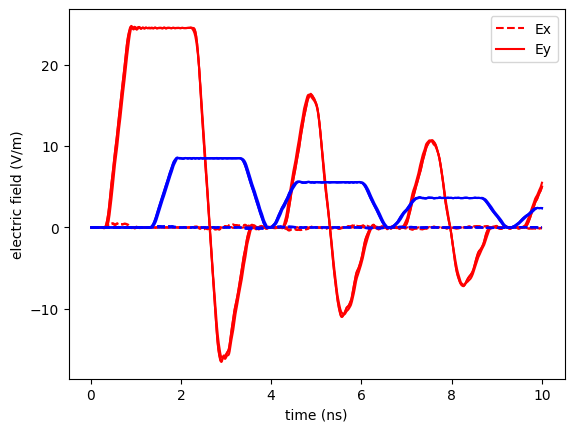

PyObject <matplotlib.legend.Legend object at 0x133e12190>

In [14]:
using PyPlot

ts = 1e9Δt * collect(1:nt)
plot(ts, res[:, 3, 1, 1], "r--", ts, res[:, 3, 1, 2], "r-")
plot(ts, res[:, 3, 2, 1], "r--", ts, res[:, 3, 2, 2], "r-")
plot(ts, res[:, 3, 3, 1], "r--", ts, res[:, 3, 3, 2], "r-")
plot(ts, res[:, 9, 1, 1], "b--", ts, res[:, 9, 1, 2], "b-")
plot(ts, res[:, 9, 2, 1], "b--", ts, res[:, 9, 2, 2], "b-")
plot(ts, res[:, 9, 3, 1], "b--", ts, res[:, 9, 3, 2], "b-")
xlabel("time (ns)")
ylabel("electric field (V/m)")
legend(["Ex", "Ey"])

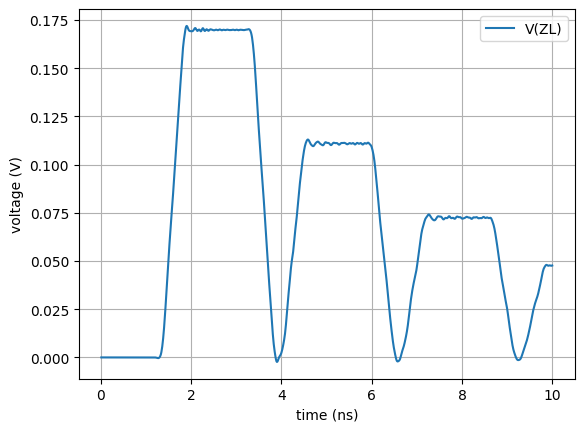

PyObject <matplotlib.legend.Legend object at 0x133e12210>

In [15]:
ts = 1e9Δt * collect(1:nt)
grid()
plot(ts, vol)
xlabel("time (ns)")
ylabel("voltage (V)")
legend(["V(ZL)"])